# ARFS - Is collinearity harmul? 
As I'll show, collinearity is harmful. All relevant feature selection methods are not 100% robust when the data have a strong correlation structure.
Many (most) feature selection schemes suffer from collinearity.



In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import catboost
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from boruta import BorutaPy as bp
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path

import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data


rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 1.2.0


In [3]:
%matplotlib inline

In [4]:
gc.enable()
gc.collect()

20

## Simple Usage
If the dataset contains multicollinear features, the permutation importance will show that none of the features are important. This is obviously a drawback. Let's illustrate how the different ARFS methods deal with collinearity and if the performance depends on the kind of feature importance (native, shap, pimp). 

For comparison purpose, I reproduce below the [scikit-learn example](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py), with added random predictors (which should be filtered out).

I'll compare to the performance when collinear features are removed, using the pre-filters included in the package. When the filter finds collinear feature, it will keep one of them, randomly chosen, which is ok since it carries the same information than the others.

The features going in the selector are : ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'
 'random_num1' 'random_num2' 'genuine_num']
The support is : [False  True False  True False False False False False False False  True
 False False  True False False False  True False False False False False
  True False False False False False  True  True  True]
The selected features are : ['mean texture' 'mean area' 'texture error' 'smoothness error'
 'symmetry error' 'worst smoothness' 'random_num1' 

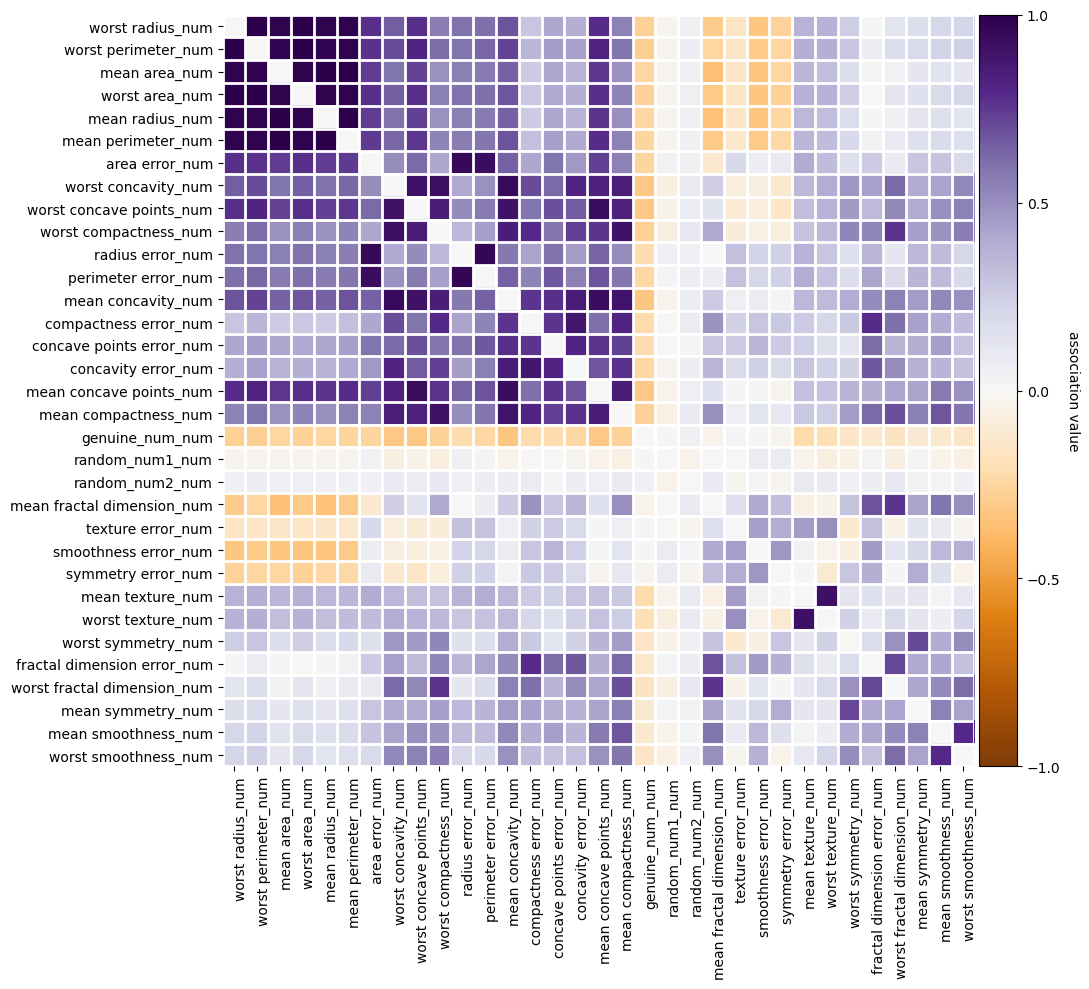

In [5]:
cancer = load_data(name="cancer")
X, y = cancer.data, cancer.target
# New instance of the class
# unsupervised learning, doesn't need a target
selector = arfsfs.CollinearityThreshold(threshold=0.75)
X_filtered = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

fig = selector.plot_association()

In [6]:
X_filtered.head()

,mean texture,mean area,texture error,smoothness error,symmetry error,worst smoothness,random_num1,random_num2,genuine_num
0,10.38,1001.0,0.9053,0.006399,0.03003,0.1622,0.496714,0,-0.249340
1,17.77,1326.0,0.7339,0.005225,0.01389,0.1238,-0.138264,1,-0.044410
2,21.25,1203.0,0.7869,0.006150,0.02250,0.1444,0.647689,3,0.128395
3,20.38,386.1,1.1560,0.009110,0.05963,0.2098,1.523030,0,-0.079921
4,14.34,1297.0,0.7813,0.011490,0.01756,0.1374,-0.234153,0,-0.094302


## Sklearn permutation importance 

The performance is clearly affected by collinearity

In [7]:
plt.style.use("fivethirtyeight")

==================== Benchmarking using sklearn permutation importance ====================


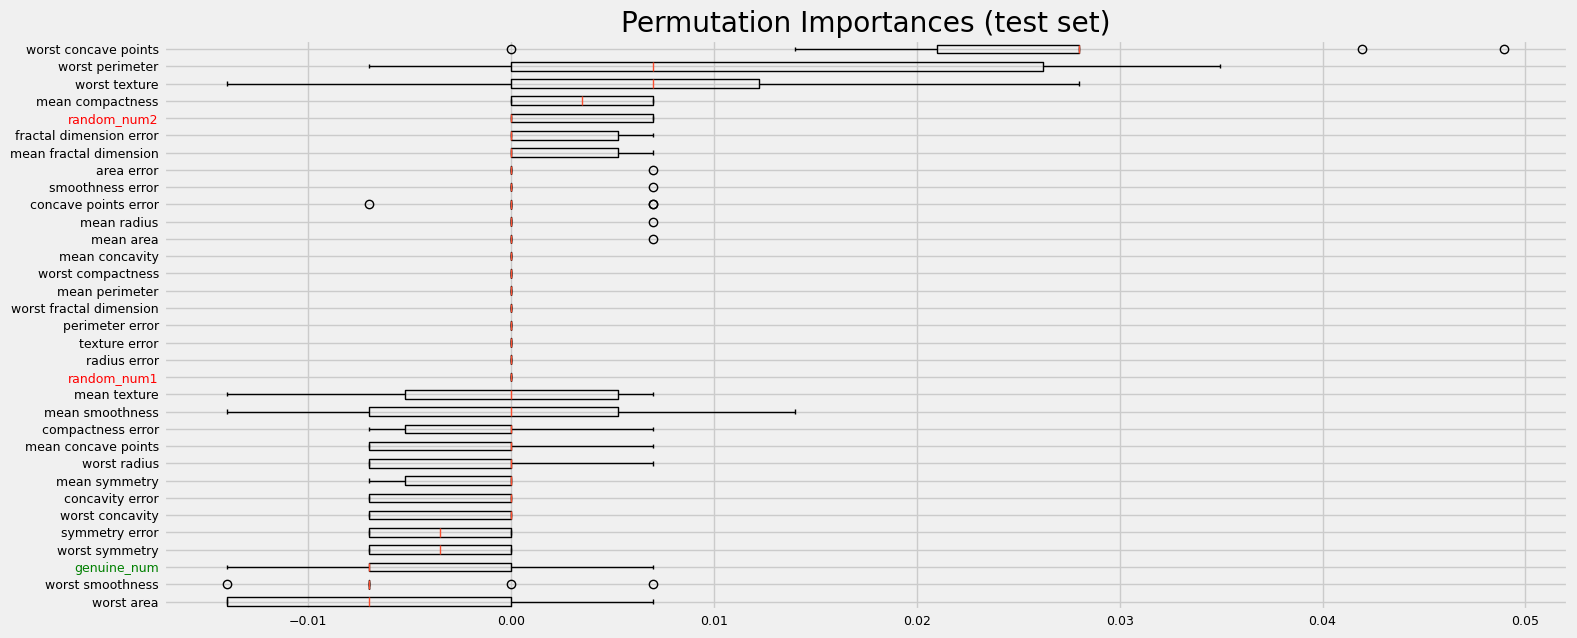

CPU times: total: 5.31 s
Wall time: 13.8 s


In [8]:
%%time
# Let's use lightgbm as booster, see below for using more models
model = LGBMClassifier(random_state=42, verbose=-1)
# Benchmark with scikit-learn permutation importance
print("=" * 20 + " Benchmarking using sklearn permutation importance " + "=" * 20)
fig = sklearn_pimp_bench(model, X, y, task="classification", sample_weight=None)

Let's repeat the permutation importance but with the collinear predictors filtered out.

==================== Benchmarking using sklearn permutation importance ====================


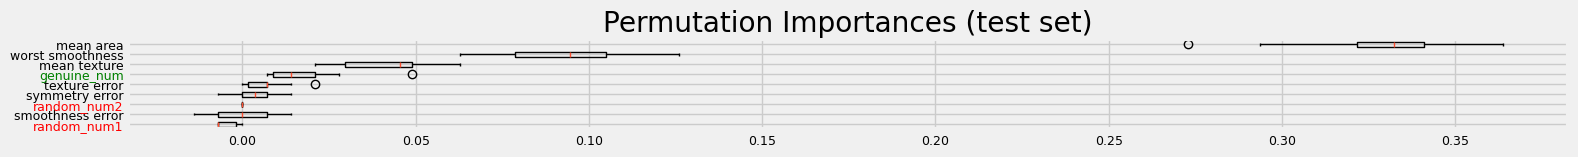

CPU times: total: 2.12 s
Wall time: 1.84 s


In [9]:
%%time
# be sure to use the same but non-fitted estimator
model = clone(model)
# Benchmark with scikit-learn permutation importance
print("=" * 20 + " Benchmarking using sklearn permutation importance " + "=" * 20)
fig = sklearn_pimp_bench(
    model, X_filtered, y, task="classification", sample_weight=None
)

The permutation importance performance looks much better when collinear predictors are filtered out.

## Leshy with permutation importance

Hereunder, I illustrate that the collinearity is problematic for the three methods of All Relevant Feature Selection. However the stability is greatly improved when the collinearity is handled.

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	2
Tentative: 	8
Rejected: 	23
All relevant predictors selected in 00:00:24.33
The selected features: ['worst perimeter' 'worst concave points']
The agnostic ranking: [ 3  2  7  2 23  3  3  2 13  7  3  7 13  2 18 18 13 13 13 13  2  2  1 22
 18  7  2  1 21 13 20 13  2]
The naive ranking: ['worst concave points', 'worst perimeter', 'worst texture', 'mean texture', 'mean concave points', 'area error', 'worst area', 'worst concavity', 'worst radius', 'worst compactness', 'mean radius', 'mean area', 'worst smoothness', 'mean concavity', 'mean perimeter', 'smoothness error', 'mean compactness', 'radius error', 'compactness error', 'mean fractal dimension', 'random_num2', 'worst fractal dimension', 'concavity error', 'symmetry error', 'concave points error', 'perimeter error', 'texture error', 'genuine_num', 'fractal dimension error', 'mean symmetry', 'random_num1', 'worst symmetry', 'mean smoothness']


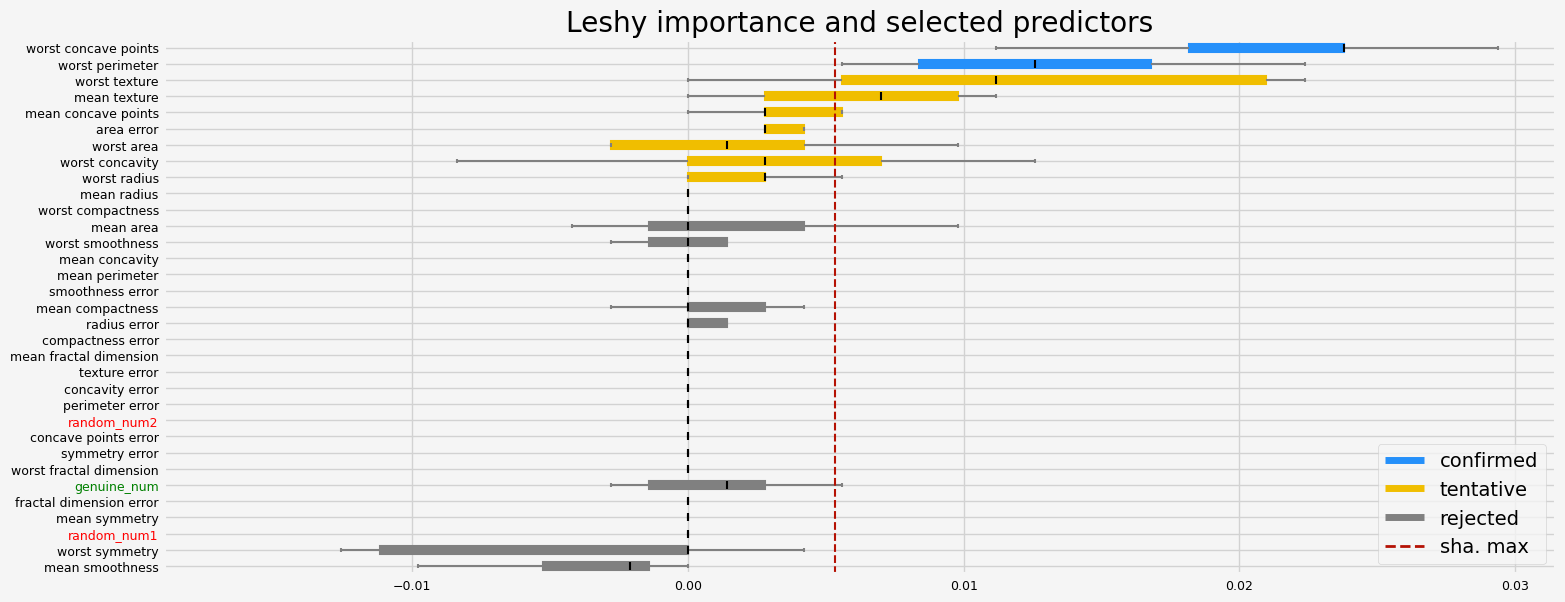

CPU times: total: 35.4 s
Wall time: 26.6 s


In [10]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# Leshy, all the predictors, no-preprocessing
feat_selector = arfsgroot.Leshy(
    model, n_estimators=100, verbose=1, max_iter=10, random_state=42, importance="pimp"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Same but collinear predictors filtered out

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using pimp var. imp.

Iteration: 	1 / 10
Confirmed: 	3
Tentative: 	2
Rejected: 	4
All relevant predictors selected in 00:00:04.83
The selected features: ['mean texture' 'mean area' 'worst smoothness']
The agnostic ranking: [1 1 2 3 4 1 5 3 2]
The naive ranking: ['mean area', 'worst smoothness', 'mean texture', 'genuine_num', 'texture error', 'smoothness error', 'random_num2', 'symmetry error', 'random_num1']


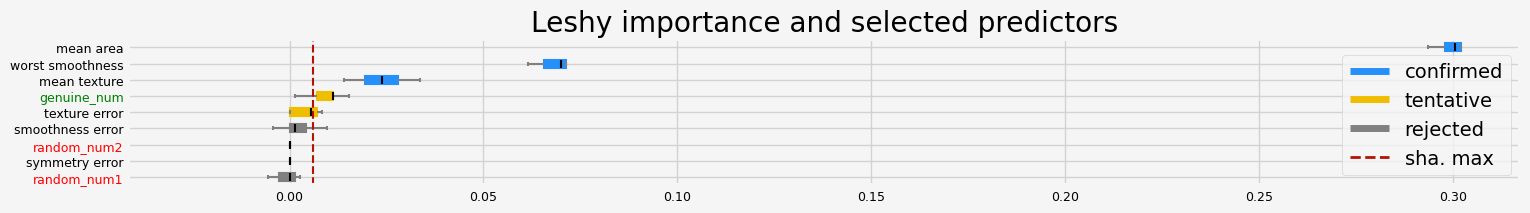

CPU times: total: 14.8 s
Wall time: 5.61 s


In [11]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# Leshy, with collinearity handled
feat_selector = arfsgroot.Leshy(
    model, n_estimators=100, verbose=1, max_iter=10, random_state=42, importance="pimp"
)
feat_selector.fit(X_filtered, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

The results are much smoother, smaller variance of the importance.

## Does SHAP feature importance suffer from the collinearity?

SHAP is a linear feature importance attribution, the importance will be split between the collinear features.

### With all the predictors

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	13
Tentative: 	3
Rejected: 	17
All relevant predictors selected in 00:00:04.94
The selected features: ['mean texture' 'mean area' 'mean smoothness' 'mean concave points'
 'area error' 'worst radius' 'worst texture' 'worst perimeter'
 'worst area' 'worst smoothness' 'worst concavity' 'worst concave points'
 'genuine_num']
The agnostic ranking: [ 7  1 15  1  1  4  3  1 13 10  2 16  6  1  5  2 17 10 13 12  1  1  1  1
  1  8  1  1  2 17  8 19  1]
The naive ranking: ['worst perimeter', 'worst concave points', 'worst area', 'mean concave points', 'worst radius', 'worst texture', 'mean area', 'worst concavity', 'mean texture', 'worst smoothness', 'mean smoothness', 'area error', 'genuine_num', 'worst symmetry', 'radius error', 'compactness error', 'mean compactness', 'mean concavity', 'smoothness error', 'perimeter error', 'fractal dimension error', 'mean radius', 'worst compactness', 'mean symmetry', 'concave poi

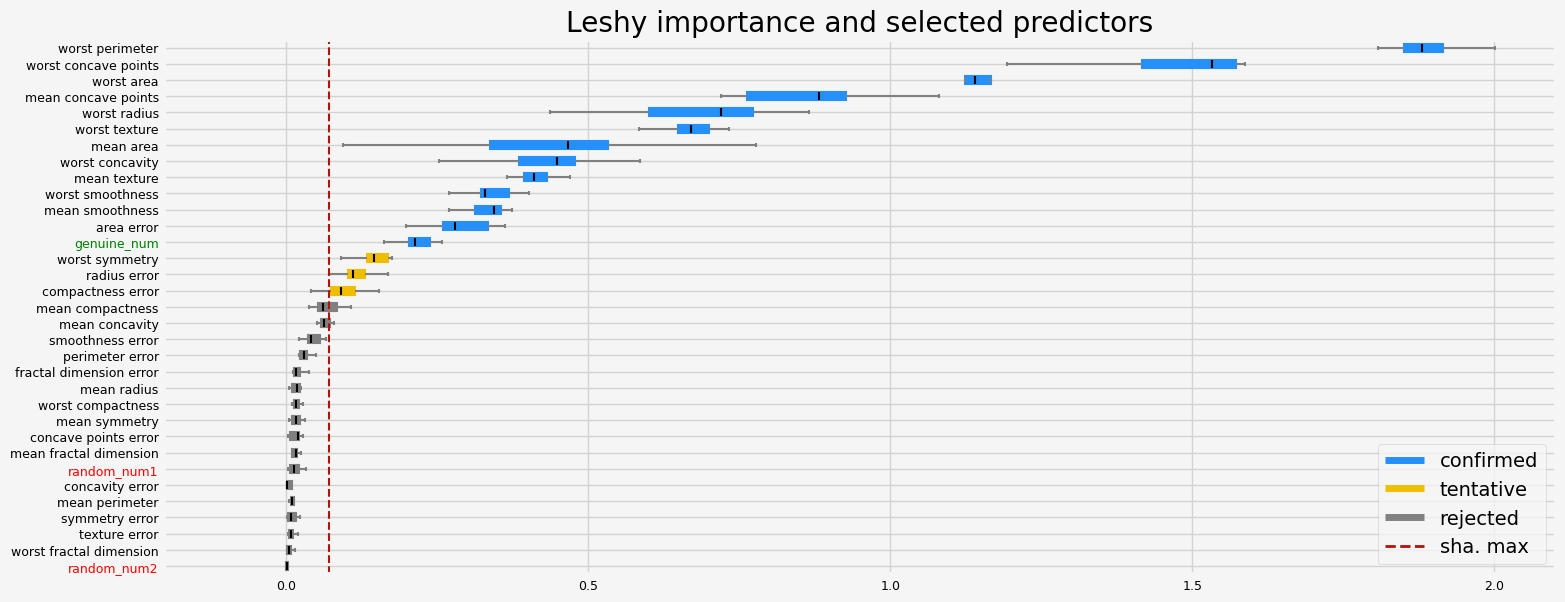

CPU times: total: 13.2 s
Wall time: 6.19 s


In [12]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=100, verbose=1, max_iter=10, random_state=42, importance="fastshap"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

### With only the filtered predictors

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	4
Tentative: 	1
Rejected: 	4
All relevant predictors selected in 00:00:03.22
The selected features: ['mean texture' 'mean area' 'worst smoothness' 'genuine_num']
The agnostic ranking: [1 1 4 2 3 1 5 6 1]
The naive ranking: ['mean area', 'worst smoothness', 'mean texture', 'genuine_num', 'smoothness error', 'symmetry error', 'texture error', 'random_num1', 'random_num2']


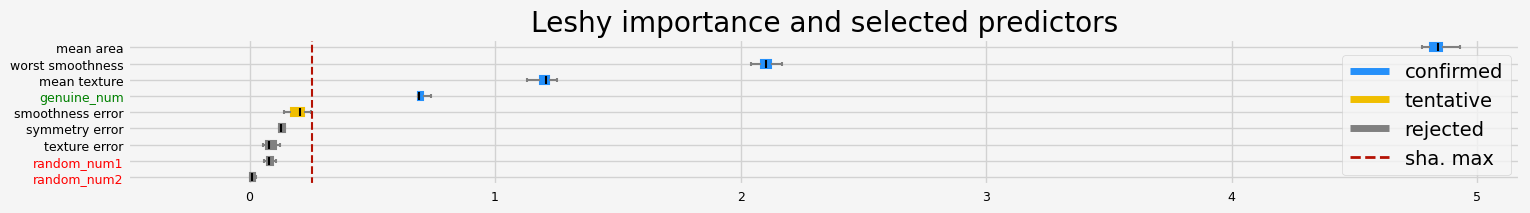

CPU times: total: 9.83 s
Wall time: 3.58 s


In [13]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# Leshy
feat_selector = arfsgroot.Leshy(
    model, n_estimators=100, verbose=1, max_iter=10, random_state=42, importance="fastshap"
)
feat_selector.fit(X_filtered, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

There is indeed much less variability in the feature importance when the collinear predictors are filtered out.

## BoostAGroota

### All the predictors

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['mean texture' 'mean area' 'mean smoothness' 'mean concave points'
 'area error' 'worst radius' 'worst texture' 'worst perimeter'
 'worst area' 'worst smoothness' 'worst concavity' 'worst concave points'
 'genuine_num']
The agnostic ranking: [1 2 1 2 2 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 1 2 2 1 1 1 1 2]
The naive ranking: ['worst perimeter', 'worst concave points', 'worst area', 'mean concave points', 'worst texture', 'worst radius', 'area error', 'mean texture', 'mean area', 'worst smoothness', 'worst concavity', 'mean smoothness', 'genuine_num', 'worst symmetry', 'radius error', 'compactness error', 'mean concavity', 'smoothness error', 'mean compactness', 'perimeter error', 'symmetry error', 'mean radius', 'concave points error', 'fractal dimension error', 'random_num1', 'texture error', 'worst compactness', 'mean fractal dimension', 'mean symmetry', 'mean perimeter', 'worst fractal dimension', 'concavity error', 'random_num2']


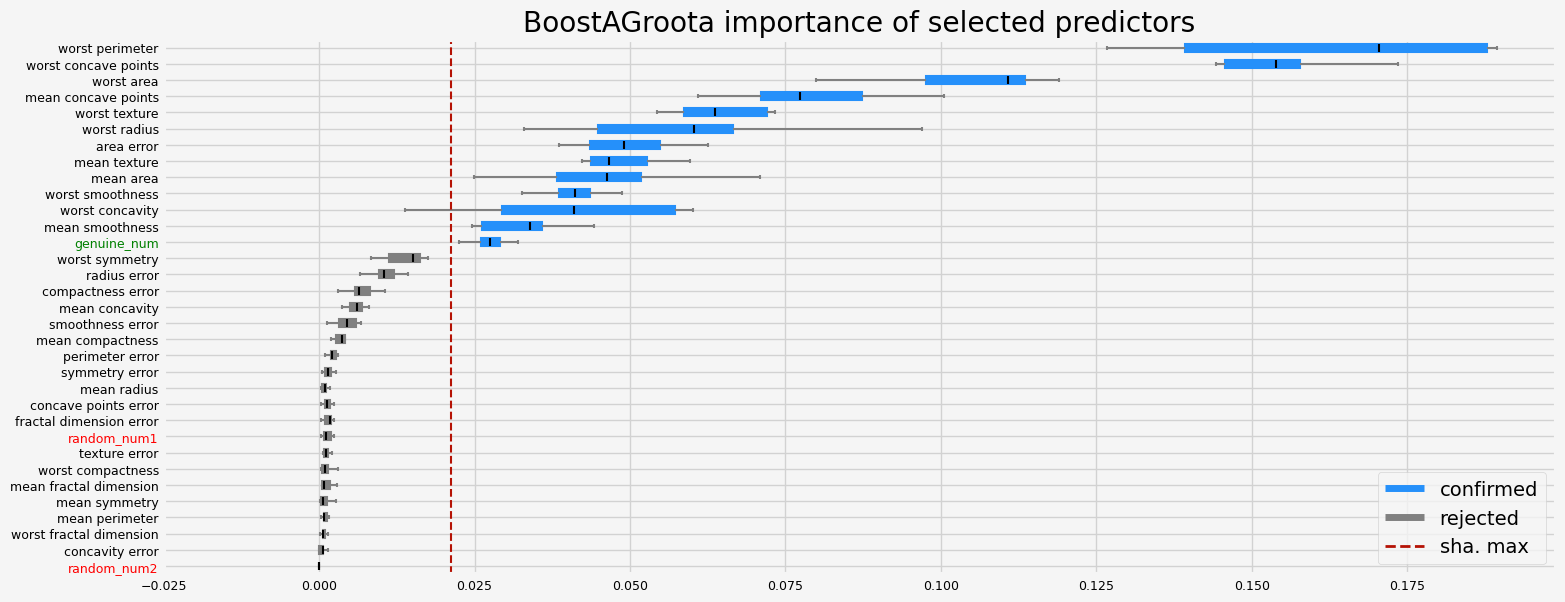

CPU times: total: 21 s
Wall time: 5.42 s


In [14]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
model = LGBMClassifier(random_state=42, verbose=-1)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

### Filtered predictors

BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['mean texture' 'mean area' 'worst smoothness' 'genuine_num']
The agnostic ranking: [2 2 1 1 1 2 1 1 2]
The naive ranking: ['mean area', 'worst smoothness', 'mean texture', 'genuine_num', 'smoothness error', 'symmetry error', 'texture error', 'random_num1', 'random_num2']


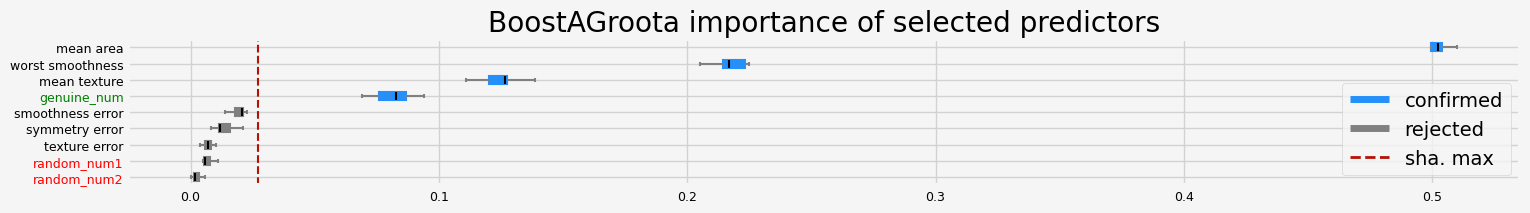

CPU times: total: 14.7 s
Wall time: 3.97 s


In [15]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X_filtered, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

Same conclusion than for Leshy, the variability is much smaller when the collinear predictors are filtered out.

## GrootCV

### All the predictors

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['mean texture' 'mean concave points' 'area error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst smoothness'
 'worst concavity' 'worst concave points' 'genuine_num']
The agnostic ranking: [1 2 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 1 2 2 1 1 1 1 2]
The naive ranking: ['worst concave points', 'worst perimeter', 'worst area', 'mean concave points', 'worst concavity', 'worst radius', 'worst texture', 'area error', 'mean texture', 'worst smoothness', 'genuine_num', 'radius error', 'mean smoothness', 'compactness error', 'mean area', 'mean concavity', 'worst symmetry', 'perimeter error', 'worst compactness', 'symmetry error', 'mean compactness', 'mean fractal dimension', 'mean symmetry', 'smoothness error', 'fractal dimension error', 'mean perimeter', 'random_num1', 'mean radius', 'texture error', 'worst fractal dimension', 'concave points error', 'concavity error', 'random_num2']


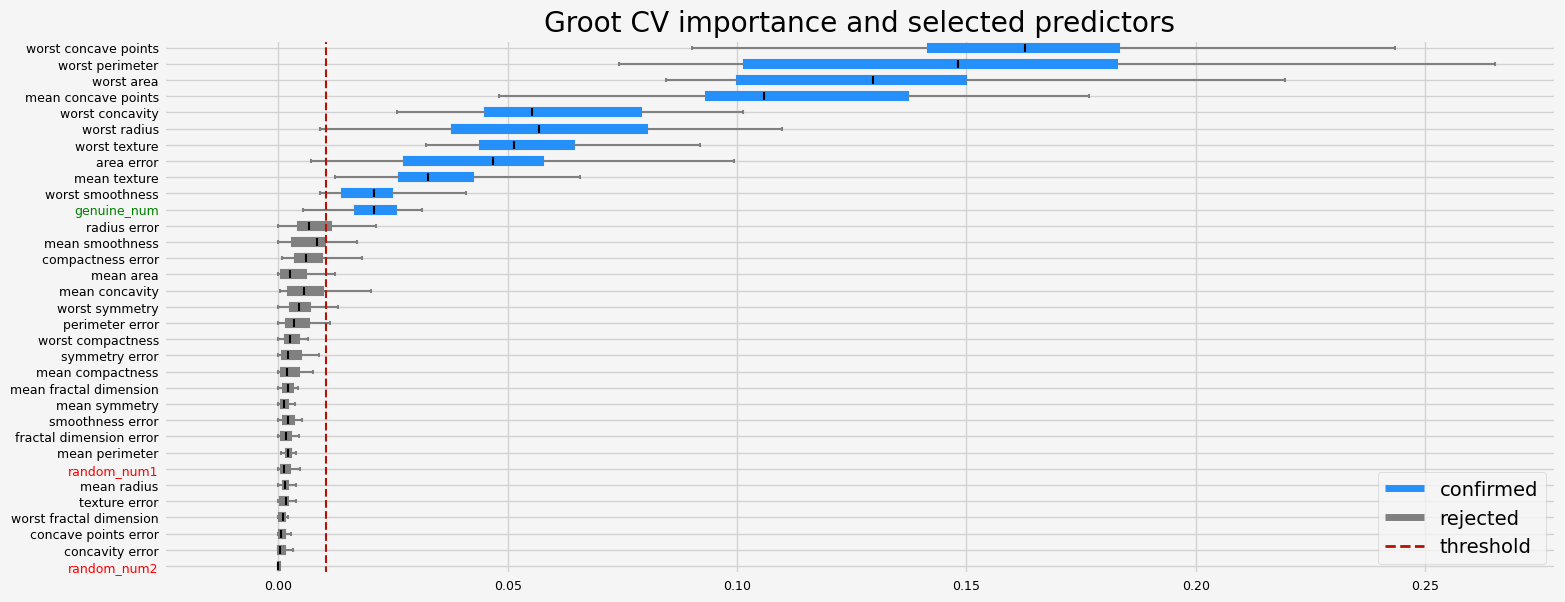

CPU times: total: 42.9 s
Wall time: 12.4 s


In [16]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(
    objective="binary", cutoff=1, n_folds=5, n_iter=5, silent=True
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

### Filtered predictors

Repeated k-fold:   0%|          | 0/25 [00:00<?, ?it/s]

The selected features: ['mean texture' 'mean area' 'worst smoothness' 'genuine_num']
The agnostic ranking: [2 2 1 1 1 2 1 1 2]
The naive ranking: ['mean area', 'worst smoothness', 'mean texture', 'genuine_num', 'smoothness error', 'symmetry error', 'texture error', 'random_num1', 'random_num2']


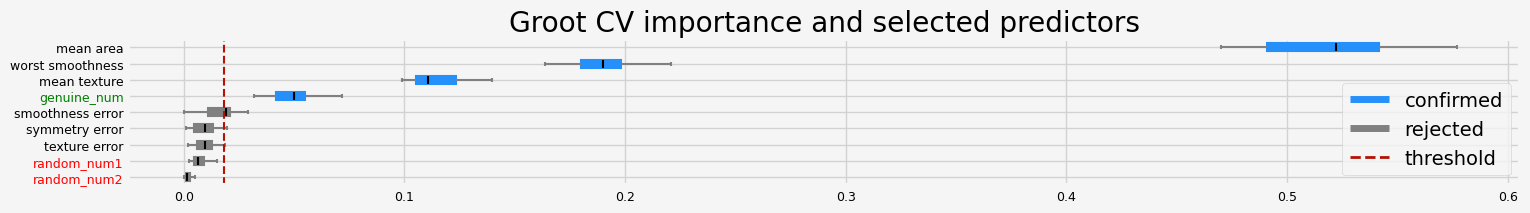

CPU times: total: 29.7 s
Wall time: 7.57 s


In [17]:
%%time

# be sure to use the same but non-fitted estimator
model = clone(model)
# GrootCV
feat_selector = arfsgroot.GrootCV(
    objective="binary", cutoff=1, n_folds=5, n_iter=5, silent=True
)
feat_selector.fit(X_filtered, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

With GrootCV, same conclusion: the variability is much smaller (smaller confidence interval) when the collinear predictors are filtered out.